In [1]:
import numpy as np
import pandas as pd
pd.set_option('max_columns', None)
pd.set_option('max_rows', 90)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.neighbors import KNeighborsRegressor
import scipy.stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_val_score

from sklearn.linear_model import BayesianRidge, HuberRegressor, Ridge, OrthogonalMatchingPursuit
from sklearn.ensemble import GradientBoostingRegressor


In [2]:
train0 = pd.read_csv("dataset/train.csv")
test0 = pd.read_csv("dataset/test.csv")
sample_submission = pd.read_csv('dataset/sample_submission.csv')

## What to do
### Describe the Datasets
train0.shape: (1460, 81)

test0.shape: (1459, 80)

Trong 81 variables cua train0 co 43 variables la co dtypes 'object' (text, cat, ...) va 38 variables la dang number.
### Muc tieu: 
Thu duoc bo du lieu de co the su dung model Linear Regression

### 4 assumptions of Linear Regression: 
https://www.statology.org/linear-regression-assumptions/

1. exists linear relationship
2. residuals are independent
3. residuals have constant variance
4. normality

### Cac buoc de thu duoc bo data thoa man assumptions tren:
1. Lam sach data: missing values va outliers
2. scater plot (univariate) va heatmap (multivariate) quan sat moi tuong quan voi vien Target. Lay ra toi da M bien (M < 80) va adding important features
3. transform data: 
+ target variable: xu li skewness de thoa man normality, scaling
+ features: voi cac numerical variables (xu li skewness, scaling); voi categorical (transform, encode)

# Step 1: Cleaning

## Step : Kiem tra su tuong quan

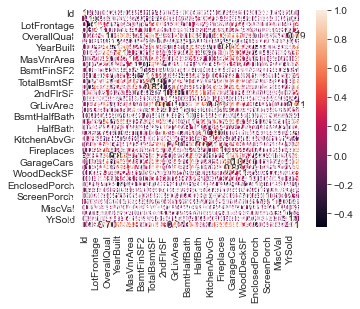

In [3]:
#correlation matrix
corrmat = train0.corr()
#saleprice correlation matrix
#k = 20 #number of variables for heatmap
#cols = corrmat.nlargest(k, 'SalePrice')['SalePrice']
#cm = np.corrcoef(data_train_8[cols].values.T)
hm = sns.heatmap(corrmat, cbar=True, annot=True, square=True)
plt.show()


In [4]:
k = 20 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice']
cols

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
GarageYrBlt     0.486362
MasVnrArea      0.477493
Fireplaces      0.466929
BsmtFinSF1      0.386420
LotFrontage     0.351799
WoodDeckSF      0.324413
2ndFlrSF        0.319334
OpenPorchSF     0.315856
HalfBath        0.284108
Name: SalePrice, dtype: float64

## Step 1.0: Combine Train and Test Sets

Lua chon combine de tiet kiem thoi gian clean 2 lan va co nhieu du lieu hon de thay the missing data hoac kiem soat outliers.


In [5]:
target = train0['SalePrice']
test_ids = test0['Id']

train1 = train0.drop(['Id', 'SalePrice'], axis=1) 
test1 = test0.drop('Id', axis = 1)

data1 = pd.concat([train1, test1], axis=0)


## Step 1.1: Kiem tra quan he

## Step 1.1: Missing values



In [7]:
data1['MSSubClass'] = data1['MSSubClass'].astype(str)
total = data1.isnull().sum().sort_values(ascending=False)
percent = (data1.isnull().sum()/data1.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(50)

,Total,Percent
PoolQC,2909,0.996574
MiscFeature,2814,0.964029
Alley,2721,0.932169
Fence,2348,0.804385
FireplaceQu,1420,0.486468
LotFrontage,486,0.166495
GarageCond,159,0.054471
GarageQual,159,0.054471
GarageYrBlt,159,0.054471
GarageFinish,159,0.054471


#### Nhan xet

1. Cac columns co missing data > 15% -> drop
2. Cach xu ly missing data cua categorical values: 

 - quen khong nhap: xu li bang cach thay bang mode 
 - chu dich de trong, vi du GarageConde co gia tri NA tuc la No Garage. Luc nay thi nen thay NA thay text "None"
3. Cach xu ly missing data cua numerical values:
 - Co ve se khong nhieu, ti nua se xu ly manually tung feature

#### Buoc 1: Drop columns co missing data > 15%

In [8]:
data2 = data1.copy()
data2.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'LotFrontage'], axis = 1, inplace = True)
object_na = pd.DataFrame(data2.select_dtypes('object').isna().sum() > 0)
object_na.index

Index(['MSSubClass', 'MSZoning', 'Street', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       'KitchenQual', 'Functional', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition'],
      dtype='object')

#### Buoc 2: Xu ly Categorical Missing Values

In [9]:
# Nhom 1: Thay gia tri na = 'None'
for column in [
    'BsmtQual',
    'BsmtCond',
    'BsmtExposure',
    'BsmtFinType1',
    'BsmtFinType2',
    'GarageType',
    'GarageFinish',
    'GarageQual',
    'GarageCond'
]:
    data2[column] = data2[column].fillna("None")

# Nhom 2: Thay cac gia tri Na = mode()
for column in [
    'MSSubClass',
    'MSZoning',
    'Utilities',
    'Exterior1st',
    'Exterior2nd',
    'MasVnrType',
    'Electrical',
    'KitchenQual',
    'Functional',
    'SaleType'
]:
    data2[column] = data2[column].fillna(data2[column].mode()[0])

#### Buoc 3: Xu ly Numerical missing values

In [10]:
data3 = data2.copy()
col_has_missing = [data3.loc[:, data3.isna().sum() > 0].select_dtypes('number').columns]
col_has_missing

[Index(['MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
        'BsmtFullBath', 'BsmtHalfBath', 'GarageYrBlt', 'GarageCars',
        'GarageArea'],
       dtype='object')]

In [11]:
missing_data.loc[['MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
        'BsmtFullBath', 'BsmtHalfBath', 'GarageYrBlt', 'GarageCars',
        'GarageArea']]

,Total,Percent
MasVnrArea,23,0.007879
BsmtFinSF1,1,0.000343
BsmtFinSF2,1,0.000343
BsmtUnfSF,1,0.000343
TotalBsmtSF,1,0.000343
BsmtFullBath,2,0.000685
BsmtHalfBath,2,0.000685
GarageYrBlt,159,0.054471
GarageCars,1,0.000343
GarageArea,1,0.000343


- MasVnrArea(Masonry veneer area in square feet): drop vi co the dung nhieu bien sibling khac thay the -> drop
- GarageYrBlt (Year garage was built): thuc te khong quan trong voi HousePrice -> drop
- Cac bien con lai chi co 1, 2 missing values -> drop luon cac dong co missing values

In [12]:
data3.drop(['MasVnrArea', 'GarageYrBlt'], axis=1, inplace=True)
data4 = data3.copy()

In [13]:
set_col = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
           'BsmtFullBath', 'BsmtHalfBath', 'GarageCars', 'GarageArea']
    
data4[set_col] = data4[set_col].fillna(data4[set_col].mean()[0])
data4.isnull().sum().max

<bound method Series.max of MSSubClass       0
MSZoning         0
LotArea          0
Street           0
LotShape         0
LandContour      0
Utilities        0
LotConfig        0
LandSlope        0
Neighborhood     0
Condition1       0
Condition2       0
BldgType         0
HouseStyle       0
OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
RoofStyle        0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
MasVnrType       0
ExterQual        0
ExterCond        0
Foundation       0
BsmtQual         0
BsmtCond         0
BsmtExposure     0
BsmtFinType1     0
BsmtFinSF1       0
BsmtFinType2     0
BsmtFinSF2       0
BsmtUnfSF        0
TotalBsmtSF      0
Heating          0
HeatingQC        0
CentralAir       0
Electrical       0
1stFlrSF         0
2ndFlrSF         0
LowQualFinSF     0
GrLivArea        0
BsmtFullBath     0
BsmtHalfBath     0
FullBath         0
HalfBath         0
BedroomAbvGr     0
KitchenAbvGr     0
KitchenQual      0
TotRmsAbvGrd     0
Fun

## Step 1.2: Outliers

https://cxl.com/blog/outliers/

Buoc 1: Detect outliers

- Boxplot, IQR, SD
- Scatter plot


Buoc 2: Handling outliers

- Transforming
- Scaling
- Imputing
- Deleting

Cai nay nam trong muc Feature Engineering!


In [14]:
data5 = data4.copy()
skew_df = pd.DataFrame(data5.select_dtypes(np.number).columns, columns=['Feature'])
skew_df['Skew'] = skew_df['Feature'].apply(lambda feature: scipy.stats.skew(data5[feature]))
skew_df['Absolute Skew'] = skew_df['Skew'].apply(abs)
skew_df['Skewed'] = skew_df['Absolute Skew'].apply(lambda x: True if x >= 0.5 else False)
data5.isnull().sum()

MSSubClass       0
MSZoning         0
LotArea          0
Street           0
LotShape         0
LandContour      0
Utilities        0
LotConfig        0
LandSlope        0
Neighborhood     0
Condition1       0
Condition2       0
BldgType         0
HouseStyle       0
OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
RoofStyle        0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
MasVnrType       0
ExterQual        0
ExterCond        0
Foundation       0
BsmtQual         0
BsmtCond         0
BsmtExposure     0
BsmtFinType1     0
BsmtFinSF1       0
BsmtFinType2     0
BsmtFinSF2       0
BsmtUnfSF        0
TotalBsmtSF      0
Heating          0
HeatingQC        0
CentralAir       0
Electrical       0
1stFlrSF         0
2ndFlrSF         0
LowQualFinSF     0
GrLivArea        0
BsmtFullBath     0
BsmtHalfBath     0
FullBath         0
HalfBath         0
BedroomAbvGr     0
KitchenAbvGr     0
KitchenQual      0
TotRmsAbvGrd     0
Functional       0
Fireplaces  

In [15]:
# Xu li Skewed data bang cach dung log transform
for column in skew_df.query("Skewed == True")['Feature'].values:
    data5[column] = np.log1p(data5[column])

# Step 2: Feature Engineering

- Step 2.1: Log transform for Skewed Featured (already)
- Step 2.2: Encode Categoricals
- Step 2.3: Scaling

In [16]:
# Step 2.1

keep_columns = ['MSZoning', 'BldgType', 'BsmtQual', 
                'BsmtCond', 'OverallQual', 'GrLivArea', 'GarageArea', 
                '1stFlrSF', 'FullBath', 'YearBuilt',
                'YearRemodAdd', 'TotRmsAbvGrd', 'Fireplaces']
data6 = data5[keep_columns]


In [17]:
# Step 2.2
data7 = data6.copy()
data7 = pd.get_dummies(data7)

In [18]:
# Step 2.3
data8 = data7.copy()
scaler = StandardScaler()
scaler.fit(data8)
data8 = pd.DataFrame(scaler.transform(data8), index=data8.index, columns=data8.columns)
data8.isnull().sum()

OverallQual         0
GrLivArea           0
GarageArea          0
1stFlrSF            0
FullBath            0
YearBuilt           0
YearRemodAdd        0
TotRmsAbvGrd        0
Fireplaces          0
MSZoning_C (all)    0
MSZoning_FV         0
MSZoning_RH         0
MSZoning_RL         0
MSZoning_RM         0
BldgType_1Fam       0
BldgType_2fmCon     0
BldgType_Duplex     0
BldgType_Twnhs      0
BldgType_TwnhsE     0
BsmtQual_Ex         0
BsmtQual_Fa         0
BsmtQual_Gd         0
BsmtQual_None       0
BsmtQual_TA         0
BsmtCond_Fa         0
BsmtCond_Gd         0
BsmtCond_None       0
BsmtCond_Po         0
BsmtCond_TA         0
dtype: int64

# Step3: Target Transformation

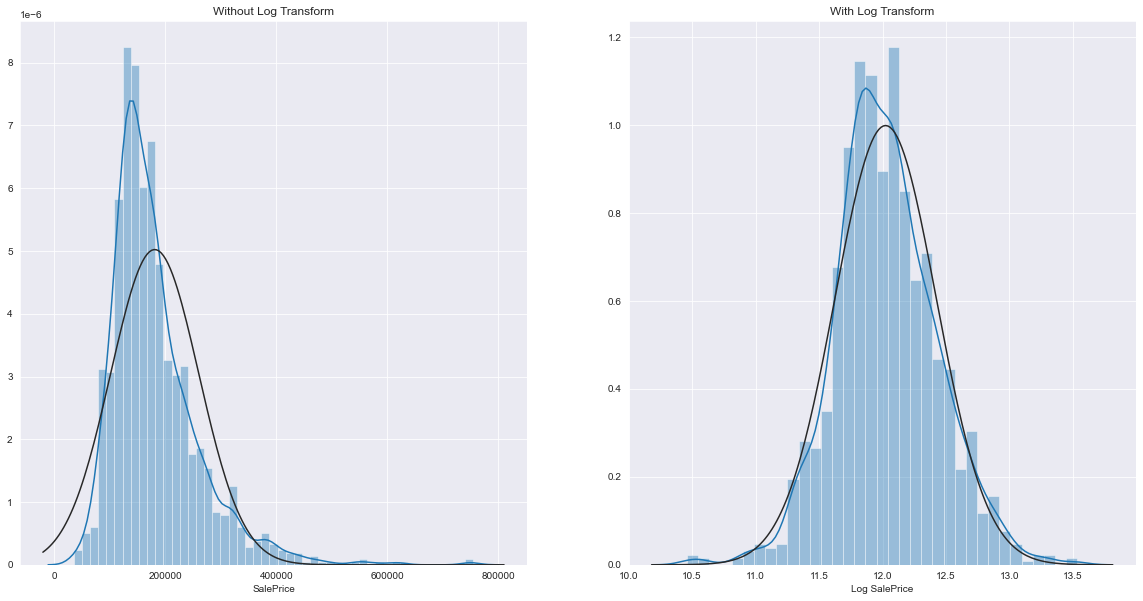

In [19]:
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
sns.distplot(target, kde=True, fit=scipy.stats.norm)
plt.title("Without Log Transform")

plt.subplot(1, 2, 2)
sns.distplot(np.log(target), kde=True, fit=scipy.stats.norm)
plt.xlabel("Log SalePrice")
plt.title("With Log Transform")

plt.show()

In [20]:
log_target = np.log(target)
log_target.shape

(1460,)

In [21]:
log_target

0       12.247694
1       12.109011
2       12.317167
3       11.849398
4       12.429216
          ...    
1455    12.072541
1456    12.254863
1457    12.493130
1458    11.864462
1459    11.901583
Name: SalePrice, Length: 1460, dtype: float64

# Step 4: Split data and Check correlation

In [22]:
data9 = data8.copy()
divided_row = train0.index.max()
train_9 = data9.iloc[:1460].copy()
test_9 = data9.iloc[1460:].reset_index(drop=True).copy()
data_train_9 = pd.concat([train_9, log_target], axis=1)

# Step 5: Modeling

https://www.kaggle.com/code/faressayah/practical-introduction-to-10-regression-algorithm

1. Split data lam 3 phan

  X_train, y_train (70% tu data_train) 
  X_eval, y_eval (30% tu data_train)

  X_test (data_test) & y_test (sample_submit file)

2. Linear Regression

3. Robust Regression

4. LASSO Regression

5. Random Forest Regressor

In [23]:
#Train Test Split

from sklearn.model_selection import train_test_split
X = data_train_9.loc[:, data_train_9.columns != 'SalePrice']
y = data_train_9['SalePrice']
X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.3, random_state=42)

X_test = test_9.copy()
y_test_df = pd.read_csv('dataset/sample_submission.csv')
y_test = np.log(y_test_df['SalePrice'])

### Evaluate Function 

In [24]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score

def cross_val(model):
    pred = cross_val_score(model, X, y, cv=10)
    return pred.mean()

def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square)
    print('__________________________________')
    
def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    return mae, mse, rmse, r2_square

### Linear Regression

In [25]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression(normalize=True)
lin_reg.fit(X_train,y_train)
pred_lin_eval = lin_reg.predict(X_eval)

pred_lin_test = lin_reg.predict(X_test)


print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, pred_lin_test)
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_eval, pred_lin_eval)


Test set evaluation:
_____________________________________
MAE: 0.30779464300602616
MSE: 0.1387834292428477
RMSE: 0.37253648041882786
R2 Square -16.125381010776838
__________________________________
Train set evaluation:
_____________________________________
MAE: 0.10697807476007438
MSE: 0.020485829448971784
RMSE: 0.14312871636737257
R2 Square 0.8792437810208099
__________________________________


### Robust Regression

In [26]:
from sklearn.linear_model import RANSACRegressor

robust_reg = RANSACRegressor(base_estimator=LinearRegression(), max_trials=100)
robust_reg.fit(X_train, y_train)

pred_robust_eval = robust_reg.predict(X_eval)

pred_robust_test = robust_reg.predict(X_test)


print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, pred_robust_test)
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_eval, pred_robust_eval)

#CHU Y TAI SAO LAI SAI SO TO THE

Test set evaluation:
_____________________________________
MAE: 8329297202.901977
MSE: 2.227982387007761e+22
RMSE: 149264275263.968
R2 Square -2.7492509351417623e+24
__________________________________
Train set evaluation:
_____________________________________
MAE: 7373711400.751227
MSE: 2.381476948113875e+22
RMSE: 154320346944.72
R2 Square -1.4037906180790082e+23
__________________________________


### Lasso

In [29]:
from sklearn.linear_model import Lasso

lasso_model = Lasso(alpha=0.1, 
              precompute=True, 
#               warm_start=True, 
              positive=True, 
              selection='random',
              random_state=42)
lasso_model.fit(X_train, y_train)


pred_lasso_eval = lasso_model.predict(X_eval)

pred_lasso_test = lasso_model.predict(X_test)


print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, pred_lasso_test)
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_eval, pred_lasso_eval)

Test set evaluation:
_____________________________________
MAE: 0.1989571785126998
MSE: 0.056518095943910274
RMSE: 0.23773534853679265
R2 Square -5.974131798901241
__________________________________
Train set evaluation:
_____________________________________
MAE: 0.15680278654192223
MSE: 0.04931786099039199
RMSE: 0.22207625039700213
R2 Square 0.7092898563772849
__________________________________


### Random Forest Regressor

In [30]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor(n_estimators=1000)
rf_reg.fit(X_train, y_train)

pred_rf_eval = rf_reg.predict(X_eval)

pred_rf_test = rf_reg.predict(X_test)


print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, pred_rf_test)
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_eval, pred_rf_eval)

Test set evaluation:
_____________________________________
MAE: 0.3012033991941091
MSE: 0.1332857391841965
RMSE: 0.3650831948805594
R2 Square -15.44698563283287
__________________________________
Train set evaluation:
_____________________________________
MAE: 0.10521274510867312
MSE: 0.02328939956011504
RMSE: 0.1526086483791631
R2 Square 0.8627177952359522
__________________________________
